## Making Imports

In [3]:
import multiprocessing
from multiprocessing.pool import ThreadPool
import pandas as pd
import numpy as np
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False

# Image Libs.
from PIL import Image
import cv2

# sklearn libs..
from sklearn.model_selection import train_test_split

# DL Libs..
import tensorflow as tf
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array,array_to_img,load_img

CWD is  D:\projects\AI projects


## Setting Up Gpu

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

## Train Validation Split and Mapping the labels with images

In [5]:
def load_data():
    train = pd.read_csv('train.csv')
   
    
    train_dir = os.path.join('./','train/')
    
    
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    
    
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")

    
    train['diagnosis'] = train['diagnosis'].astype(str)
    
    return train

In [6]:
df_train = load_data()
print(df_train.shape,'\n')
df_train.head(6)

(4184, 4) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,./train/000c1434d8d7.png,000c1434d8d7.png
1,001639a390f0,4,./train/001639a390f0.png,001639a390f0.png
2,0024cdab0c1e,1,./train/0024cdab0c1e.png,0024cdab0c1e.png
3,002c21358ce6,0,./train/002c21358ce6.png,002c21358ce6.png
4,005b95c28852,0,./train/005b95c28852.png,005b95c28852.png
5,0083ee8054ee,4,./train/0083ee8054ee.png,0083ee8054ee.png


## Seeing classes distribution in train and validation data

In [5]:
'''This Function Plots a Bar plot of output Classes Distribution'''

def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show() 

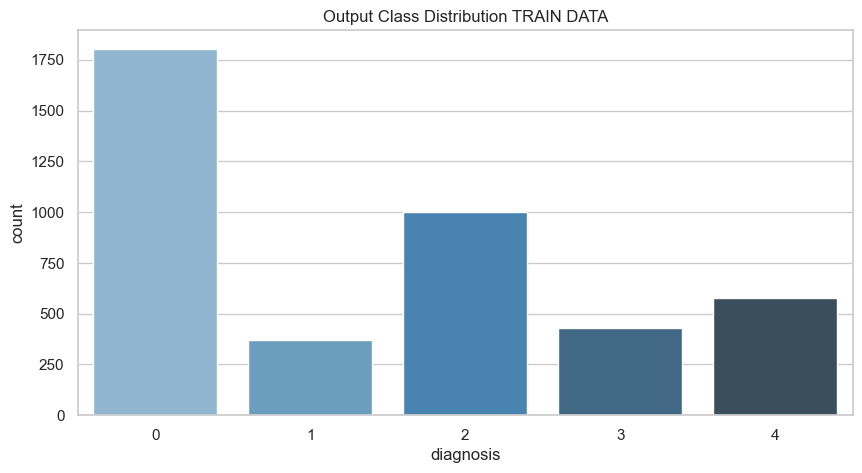

In [7]:
plot_classes(df_train,"TRAIN DATA")

## Image processing

In [7]:
IMG_SIZE = 512

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def circle_crop(img, sigmaX = 30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('./','train','{}.png'.format(file))
    output_filepath = os.path.join('./','preprocessed images','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
    
def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results

## Creating the model

In [8]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 15
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = df_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [9]:
df_train.shape


(4184, 4)

In [10]:
def img_generator(df_train):
    

    
    
    train_datagen=ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True
    )
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="./preprocessed images/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                                      directory="./preprocessed images/",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical", 
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation'
                                                      )
    
    
    return train_generator,valid_generator

In [ ]:
train_generator,valid_generator = img_generator(df_train)

In [13]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

393 98


In [18]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(5, activation='softmax'))


In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,
                    )


In [41]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

def ResNet50_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, include_top=False,input_tensor=input_tensor)
    base_model.load_weights('C:/Users/Salah/.keras/models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

model = ResNet50_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)


for layer in model.layers:
    layer.trainable = True


rlrop = ReduceLROnPlateau(monitor='val_loss', mode='auto', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])

history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=15,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/2
393/393 [==============================] - 29s 67ms/step - loss: 1.4518 - accuracy: 0.4264 - val_loss: 1.3050 - val_accuracy: 0.5128
Epoch 2/2
393/393 [==============================] - 26s 65ms/step - loss: 1.2999 - accuracy: 0.4583 - val_loss: 1.2591 - val_accuracy: 0.5179
Epoch 1/15
393/393 [==============================] - 62s 141ms/step - loss: 1.3452 - accuracy: 0.6093 - val_loss: 1.2559 - val_accuracy: 0.4643 - lr: 1.0000e-04
Epoch 2/15
393/393 [==============================] - 54s 138ms/step - loss: 0.8221 - accuracy: 0.6619 - val_loss: 1.0578 - val_accuracy: 0.6556 - lr: 1.0000e-04
Epoch 3/15
393/393 [==============================] - 54s 137ms/step - loss: 0.7283 - accuracy: 0.7014 - val_loss: 0.7716 - val_accuracy: 0.7130 - lr: 1.0000e-04
Epoch 4/15
393/393 [==============================] - 54s 138ms/step - loss: 0.6731 - accuracy: 0.7231 - val_loss: 0.6322 - val_accuracy: 0.7640 - lr: 1.0000e-04
Epoch 5/15
393/393 [==============================] - 54s 137ms/st

In [39]:
model.save('ResNet50 Diabetic Retinopathy final with 3&4 augmentation 1024 dense.h5')

In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB5


def EfficientNetB5_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB5(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    base_model.load_weights('C:/Users/Salah/.keras/models/efficientnetb5_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model


for layer in model.layers:
    layer.trainable = True


rlrop = ReduceLROnPlateau(monitor='val_loss', mode='auto', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [rlrop] 
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])

history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=15,
                                          callbacks=callback_list,
                                          verbose=1).history
model.save('EfficientNetB5 Diabetic Retinopathy final with 3 augmentation 5 classes.h5')

In [ ]:
def VGG16_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)

    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

    # Freeze the layers of the VGG16 model
    for layer in vgg_model.layers:
        layer.trainable = False

    # Create a new model
    model = Sequential()
    model.add(vgg_model)
    model.add(keras.layers.Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    # Compile the model
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = VGG16_model(input_shape=(224, 224, CANAL), n_out=N_CLASSES)


for layer in model.layers:
    layer.trainable = True


rlrop = ReduceLROnPlateau(monitor='val_loss', mode='auto', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [rlrop] 
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])

history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=15,
                                          callbacks=callback_list,
                                          verbose=1).history

model.save('VGG16-diabetic retinopathy class 3&4 augmented.h5')

In [ ]:
def DenseNet_model(input_shape, n_out):
    DenseNet121_model = DenseNet121(include_top=False, weights=None,
                                    input_tensor=keras.layers.Input(shape=(HEIGHT, WIDTH, 3)))
    DenseNet121_model.load_weights('D://Faculty//Semester 6//AI Diabetic Retinopathy//DenseNet-BC-121-32-no-top.h5')


    p = keras.layers.GlobalAveragePooling2D()(DenseNet121_model.output)

    d11 = keras.layers.Dense(units=256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(p)
    o1 = keras.layers.Dense(units=5, activation='softmax')(d11)
    model = keras.models.Model(inputs=DenseNet121_model.input, outputs=o1)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model

model = DenseNet_model(input_shape=(224, 224, CANAL), n_out=N_CLASSES)



for layer in model.layers:
    layer.trainable = True


rlrop = ReduceLROnPlateau(monitor='val_loss', mode='auto', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [rlrop] 
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])

history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=15,
                                          callbacks=callback_list,
                                          verbose=1).history

model.save('DenseNet-diabetic retinopathy class 3&4 augmented.h5')

In [19]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
import numpy as np

def predict_labels_return(modelName):
    model_path = "D:\\projects\\AI projects\\"+modelName
    model = load_model(model_path)

    test_generator = valid_generator 
    true_labels = test_generator.classes
    
    print("training accuracy:",model.evaluate(train_generator)[1])
    print("\n")
    print("validation accuracy:",model.evaluate(valid_generator)[1])
    print("\n")

    # Generate predictions
    predicted_labels = []
    for images in test_generator.filepaths:
        image_path="D:\\projects\\AI projects\\"+images
        img = image.load_img(image_path, target_size=(HEIGHT, WIDTH))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0
        predictions = model.predict(img_array)
        predicted_class = np.argmax(predictions)
        predicted_labels.append(predicted_class)# Assuming it's a classification task
    return true_labels,predicted_labels


In [20]:
def calculate_metrics(true_labels,predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    print("Confusion Matrix:\n")
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0,1,2,3,4])
    cm_display.plot()
    plt.show()
    print("\n")
    print(classification_report(true_labels, predicted_labels))

In [ ]:
true_labels,predicted_labels = predict_labels_return("DenseNet-diabetic retinopathy class 3&4 augmented.h5")

Confusion Matrix:



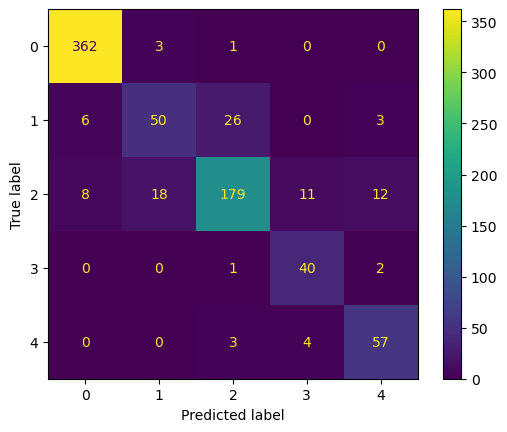



              precision    recall  f1-score   support

           0       0.96      0.99      0.98       366
           1       0.70      0.59      0.64        85
           2       0.85      0.79      0.82       228
           3       0.73      0.93      0.82        43
           4       0.77      0.89      0.83        64

    accuracy                           0.88       786
   macro avg       0.80      0.84      0.82       786
weighted avg       0.87      0.88      0.87       786



In [22]:
calculate_metrics(true_labels,predicted_labels)

In [ ]:
true_labels,predicted_labels = predict_labels_return("EfficientNetB5 Diabetic Retinopathy final with 3&4 augmentation.h5")

Confusion Matrix:



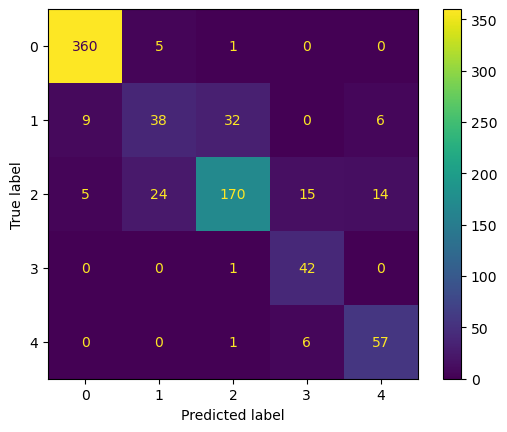



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       366
           1       0.57      0.45      0.50        85
           2       0.83      0.75      0.79       228
           3       0.67      0.98      0.79        43
           4       0.74      0.89      0.81        64

    accuracy                           0.85       786
   macro avg       0.75      0.81      0.77       786
weighted avg       0.85      0.85      0.84       786



In [24]:
calculate_metrics(true_labels,predicted_labels)

In [ ]:
true_labels,predicted_labels = predict_labels_return("VGG16-diabetic retinopathy class 3&4 augmented.h5")

Confusion Matrix:



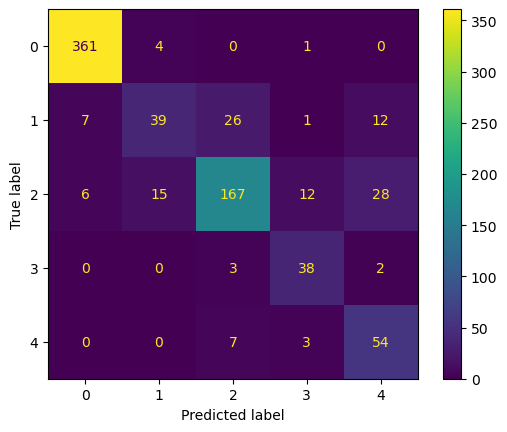



              precision    recall  f1-score   support

           0       0.97      0.99      0.98       366
           1       0.67      0.46      0.55        85
           2       0.82      0.73      0.77       228
           3       0.69      0.88      0.78        43
           4       0.56      0.84      0.68        64

    accuracy                           0.84       786
   macro avg       0.74      0.78      0.75       786
weighted avg       0.84      0.84      0.84       786



In [26]:
calculate_metrics(true_labels,predicted_labels)

In [ ]:
true_labels,predicted_labels = predict_labels_return("ResNet50 Diabetic Retinopathy final with 3&4 augmentation 1024 dense.h5")

Confusion Matrix:



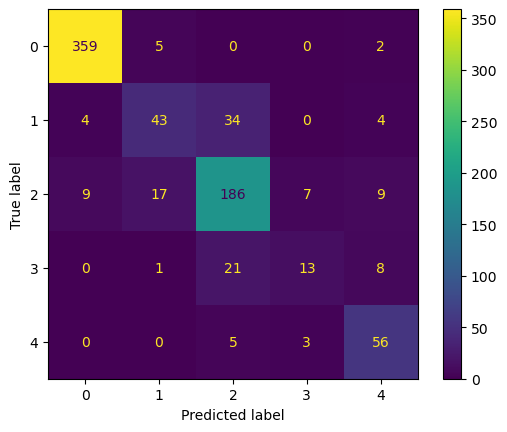



              precision    recall  f1-score   support

           0       0.97      0.98      0.97       366
           1       0.65      0.51      0.57        85
           2       0.76      0.82      0.78       228
           3       0.57      0.30      0.39        43
           4       0.71      0.88      0.78        64

    accuracy                           0.84       786
   macro avg       0.73      0.70      0.70       786
weighted avg       0.83      0.84      0.83       786



In [28]:
calculate_metrics(true_labels,predicted_labels)

In [32]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image

model_path = "D:\\projects\\AI projects\\DenseNet-diabetic retinopathy class 3&4 augmented.h5"
model = load_model(model_path)

# Load and preprocess the image
image_path = "D:/projects/AI projects/preprocessed images/144a1a426137.png"
img = image.load_img(image_path, target_size=(HEIGHT, WIDTH))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Assuming you used rescaling in your training data

# Use the model to predict
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions)  # Assuming it's a classification task

# Print the predicted class
print("Predicted class:", predicted_class)

1/1 [==============================] - 2s 2s/step
Predicted class: 0


In [28]:
filenames = valid_generator.filenames
print("Filenames in the valid generator:")
print(filenames)

# Accessing the labels in the valid generator
labels = valid_generator.labels
print("Labels in the valid generator:")
print(labels)

Filenames in the valid generator:
['000c1434d8d7.png', '001639a390f0.png', '0024cdab0c1e.png', '002c21358ce6.png', '005b95c28852.png', '0083ee8054ee.png', '0097f532ac9f.png', '00a8624548a9.png', '00b74780d31d.png', '00cb6555d108.png', '00cc2b75cddd.png', '00e4ddff966a.png', '00f6c1be5a33.png', '0104b032c141.png', '0124dffecf29.png', '0125fbd2e791.png', '012a242ac6ff.png', '014508ccb9cb.png', '0151781fe50b.png', '0161338f53cc.png', '0180bfa26c0b.png', '0182152c50de.png', '01b3aed3ed4c.png', '01c7808d901d.png', '01d9477b1171.png', '01eb826f6467.png', '01f7bb8be950.png', '0212dd31f623.png', '022f820027b8.png', '0231642cf1c2.png', '0232dfea7547.png', '02358b47ea89.png', '0243404e8a00.png', '025a169a0bb0.png', '02685f13cefd.png', '026dcd9af143.png', '02cd34a85b24.png', '02da652c74b8.png', '02dda30d3acf.png', '0304bedad8fe.png', '0318598cfd16.png', '032d7b0b4bf6.png', '033f2b43de6d.png', '034cb07a550f.png', '03676c71ed1b.png', '0369f3efe69b.png', '03747397839f.png', '03a7f4a5786f.png', '03b3

In [29]:
print(valid_generator.filenames[13])

0104b032c141.png


In [32]:
image_label_map = {}

for i in range(len(filenames)):
    image_label_map[filenames[i]] = labels[i]

print(image_label_map)

{'000c1434d8d7.png': 2, '001639a390f0.png': 4, '0024cdab0c1e.png': 1, '002c21358ce6.png': 0, '005b95c28852.png': 0, '0083ee8054ee.png': 4, '0097f532ac9f.png': 0, '00a8624548a9.png': 2, '00b74780d31d.png': 2, '00cb6555d108.png': 1, '00cc2b75cddd.png': 0, '00e4ddff966a.png': 2, '00f6c1be5a33.png': 0, '0104b032c141.png': 3, '0124dffecf29.png': 1, '0125fbd2e791.png': 0, '012a242ac6ff.png': 2, '014508ccb9cb.png': 0, '0151781fe50b.png': 0, '0161338f53cc.png': 2, '0180bfa26c0b.png': 2, '0182152c50de.png': 0, '01b3aed3ed4c.png': 1, '01c7808d901d.png': 2, '01d9477b1171.png': 0, '01eb826f6467.png': 2, '01f7bb8be950.png': 0, '0212dd31f623.png': 0, '022f820027b8.png': 0, '0231642cf1c2.png': 0, '0232dfea7547.png': 0, '02358b47ea89.png': 0, '0243404e8a00.png': 4, '025a169a0bb0.png': 2, '02685f13cefd.png': 4, '026dcd9af143.png': 2, '02cd34a85b24.png': 0, '02da652c74b8.png': 0, '02dda30d3acf.png': 4, '0304bedad8fe.png': 0, '0318598cfd16.png': 4, '032d7b0b4bf6.png': 2, '033f2b43de6d.png': 2, '034cb07a5